## Predict Wine Scores Based On Their Reviews

### Loading data

In [ ]:
from google.colab import files
 
 
uploaded = files.upload()

Saving winemagdata_first150k.csv to winemagdata_first150k.csv


In [ ]:
import pandas as pd 
import os 
import seaborn as sns 
from sklearn import metrics
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud

wine_data = pd.read_csv("winemagdata_first150k.csv", index_col = False)

### Observe the overal data distribution

In [ ]:

wine_data.describe()

,Unnamed: 0,points,price
count,150930.000000,150930.000000,137235.000000
mean,75464.500000,87.888418,33.131482
std,43569.882402,3.222392,36.322536
min,0.000000,80.000000,4.000000
25%,37732.250000,86.000000,16.000000
50%,75464.500000,88.000000,24.000000
75%,113196.750000,90.000000,40.000000
max,150929.000000,100.000000,2300.000000


In [ ]:
# no missing values
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


Exploratory wine_data Analysis

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))
detokenizer = TreebankWordDetokenizer()

#Remove all stop words and 
def cleaning_words(description):
    description = word_tokenize(description.lower())
    description = [token for token in description if token not in stopwords and token.isalpha()]
    return detokenizer.detokenize(description)

wine_data["new_desc"] = wine_data["description"].apply(cleaning_words)




In [ ]:
wine_data["new_desc"]

0         tremendous varietal wine hails oakville aged t...
1         ripe aromas fig blackberry cassis softened swe...
2         mac watson honors memory wine made mother trem...
3         spent months new french oak incorporates fruit...
4         top wine la bégude named highest point vineyar...
                                ...                        
150925    many people feel fiano represents southern ita...
150926    offers intriguing nose ginger lime floral elem...
150927    classic example comes cru vineyard called terr...
150928    perfect salmon shade scents peaches cherries t...
150929    pinot grigios taste like rich nose followed cr...
Name: new_desc, Length: 150930, dtype: object

In [ ]:
all_words = " ".join(wine_data["new_desc"])
# all_words

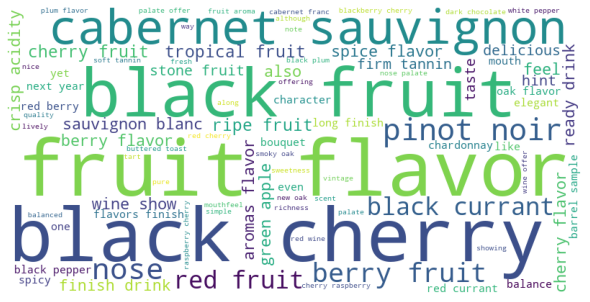

In [ ]:
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Prices vary by countries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

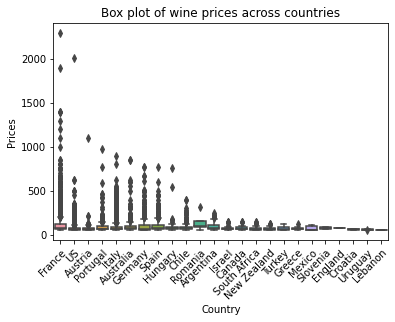

In [ ]:
#Extract the most expensive wines
priceVScountry = wine_data[["price", "country"]].dropna(how = "any").nlargest(20000, "price")


ax = sns.boxplot(x="country", y = "price", data=priceVScountry)
ax.set_title("Box plot of wine prices across countries")
ax.set(xlabel = "Country", ylabel = "Prices")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

#### Train model

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
review_train, review_test, y_train, y_test = train_test_split(wine_data["new_desc"], wine_data["points"], test_size=0.25, random_state=102300)

In [ ]:
tokenizer = Tokenizer(num_words=7000)
tokenizer.fit_on_texts(review_train)

X_train = tokenizer.texts_to_sequences(review_train)
X_test = tokenizer.texts_to_sequences(review_test)

vocab_size = len(tokenizer.word_index) + 1  # reserve 0 empty index

print(list(review_train)[2])
print(X_train[2])

aromas plum pressed violet toasted oak whiff exotic spice lead nose palate offers dried black cherry raisin licorice espresso black pepper alongside tannins
[5, 30, 917, 554, 244, 17, 540, 219, 14, 248, 24, 9, 43, 100, 11, 8, 419, 101, 361, 11, 47, 323, 7]


Plot histogram of number of words per review in order to now the max length of tokenizing

(array([1.9600e+02, 6.4370e+03, 3.4497e+04, 4.6750e+04, 1.9025e+04,
        5.3440e+03, 8.0500e+02, 1.1100e+02, 2.8000e+01, 4.0000e+00]),
 array([ 0. ,  6.8, 13.6, 20.4, 27.2, 34. , 40.8, 47.6, 54.4, 61.2, 68. ]),
 <a list of 10 Patch objects>)

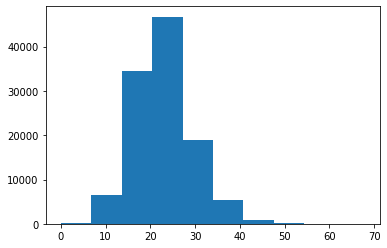

In [ ]:
num_words_per_review = list(map(len,X_train))
plt.hist(num_words_per_review)

In [ ]:
#based on the number of words distribution, we choose 70 as the max number of words per sentence
max_len =70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, kernel_initializer="normal"))

checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
callback = [checkpoint, early]

model.compile( optimizer='adam',
    loss='mse',
    metrics=[metrics.mse])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 100)           2725300   
                                                                 
 conv1d (Conv1D)             (None, 66, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 32)                352       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                        

In [ ]:
def plot_history(history):
    error = history.history['mean_squared_error']
    val_error = history.history['val_mean_squared_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(error) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, error, 'b', label='Training error')
    plt.plot(x, val_error, 'r', label='Validation error')
    plt.title('Training and validation error')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


Epoch 1: val_loss improved from inf to 9.68907, saving model to model.h5

Epoch 2: val_loss did not improve from 9.68907

Epoch 3: val_loss did not improve from 9.68907

Epoch 4: val_loss improved from 9.68907 to 9.60643, saving model to model.h5

Epoch 5: val_loss improved from 9.60643 to 9.59604, saving model to model.h5

Epoch 6: val_loss did not improve from 9.59604

Epoch 7: val_loss improved from 9.59604 to 9.55297, saving model to model.h5

Epoch 8: val_loss did not improve from 9.55297

Epoch 9: val_loss did not improve from 9.55297

Epoch 10: val_loss did not improve from 9.55297

Epoch 11: val_loss did not improve from 9.55297

Epoch 12: val_loss did not improve from 9.55297

Epoch 13: val_loss did not improve from 9.55297

Epoch 14: val_loss did not improve from 9.55297

Epoch 15: val_loss improved from 9.55297 to 9.50010, saving model to model.h5

Epoch 16: val_loss improved from 9.50010 to 9.48990, saving model to model.h5

Epoch 17: val_loss did not improve from 9.48990


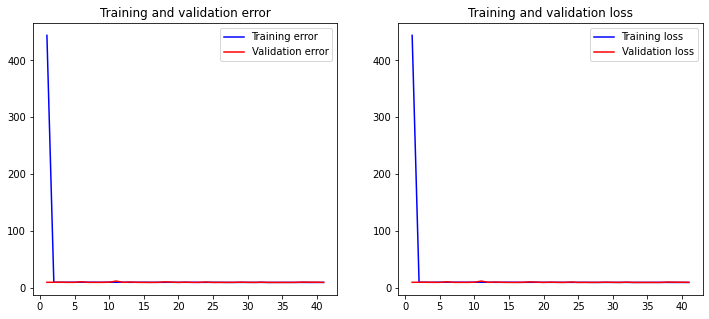

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=128, 
                   callbacks=callback)
loss, mse = model.evaluate(X_train, y_train, verbose=False)
print("Training error: {:.4f}".format(mse))
loss, mse = model.evaluate(X_test, y_test, verbose=False)
print("Testing error:  {:.4f}".format(mse))
plot_history(history)

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow 

from tensorflow import keras
from keras.layers import Dense
model = load_model ("model.h5")

In [ ]:
model.history

In [ ]:
saved_model = tf.keras.models.load_model('model.h5')
saved_model.load_weights('model.h5')
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 100)           2725300   
                                                                 
 conv1d (Conv1D)             (None, 66, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 32)                352       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                        

#### Evaluation and Accuracy

In [ ]:
train_labels = y_train>np.mean(y_train) #pd.qcut(y_train, q =2, labels = ["low","high"])
test_labels = y_test>np.mean(y_test) #pd.qcut(y_test, q =2, labels = ["low","high"])
testpreds= -model.predict(X_test).flatten()
testpredlabels = testpreds>np.mean(testpreds) #pd.qcut(testpreds, q =2, labels = ["low","high"])
trainpreds= -model.predict(X_train).flatten()
trainpredlabels = trainpreds>np.mean(trainpreds) #pd.qcut(trainpreds, q =2, labels = ["low","high"])

3538/3538 [==============================] - 34s 10ms/step


In [ ]:
from sklearn import datasets 

In [ ]:
from sklearn import metrics

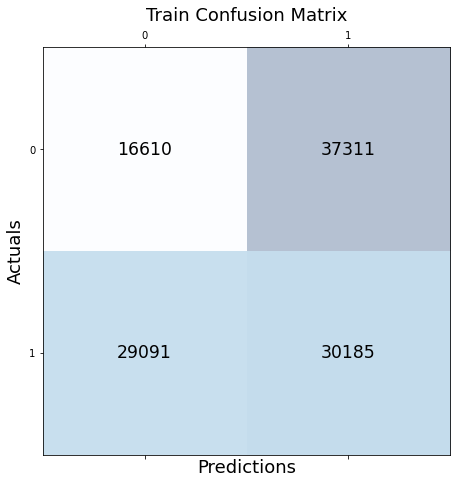

In [ ]:
conf_matrix = metrics.confusion_matrix(y_true=train_labels, y_pred=trainpredlabels)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Train Confusion Matrix', fontsize=18)
plt.show()

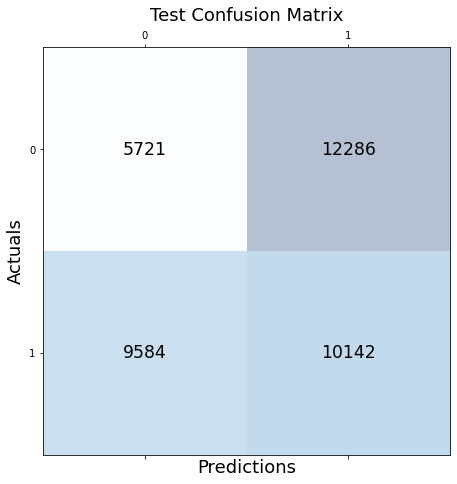

In [ ]:
conf_matrix = metrics.confusion_matrix(y_true=test_labels, y_pred=testpredlabels)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Test Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print("TRAIN accuracy score:",metrics.accuracy_score(train_labels, trainpredlabels))
print("TEST accuracy score:",metrics.accuracy_score(test_labels, testpredlabels))

TRAIN accuracy score: 0.4133943479067466
TEST accuracy score: 0.4204012402936422
